In [1]:
pwd

'C:\\Users\\user'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

tf.config.list_physical_devices('GPU')

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import cv2

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from keras.utils.layer_utils import count_params

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras.models import load_model


In [4]:
# Define Image Augmentation and Training Parameters

class Config:
    DATA_AUG_ON = True
    DATA_AUG_ROTATE = 20
    DATA_AUG_FLIP = True
    DATA_AUG_WIDTH_SHIFT = 0.2
    DATA_AUG_HEIGHT_SHIFT = 0.2
    DATA_AUG_ZOOM = 0.2
    DATA_AUG_SHEAR = 0.2
    MODEL_TRAIN_EPOCHS = [20]
    MODEL_TRAIN_LEARN_RATE = [0.001]
    MODEL_TRAIN_BATCH_SIZE = 32
    MODEL_TRAIN_FIRST_TRAINABLE_LAYER = 200

config = Config()

In [5]:
# Define Base Model

base_model = InceptionV3(weights = 'imagenet', include_top = False)

MODEL_TRAINABLE_BASE = True

if MODEL_TRAINABLE_BASE:
    base_model.trainable = True
    if config.MODEL_TRAIN_FIRST_TRAINABLE_LAYER:
        for layer in base_model.layers[:config.MODEL_TRAIN_FIRST_TRAINABLE_LAYER]:
            layer.trainable = False
        for layer in base_model.layers[config.MODEL_TRAIN_FIRST_TRAINABLE_LAYER:]:
            layer.trainable = True
else:
    base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(32, activation = 'relu', kernel_regularizer = regularizers.l2(5e-3),
                bias_regularizer = regularizers.l2(5e-3))(x)
x = Dense(1, activation = 'sigmoid', name = 'output')(x)

model = Model(inputs = base_model.input, outputs = x)

# print(model.summary())

trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)
print('Total Parameters: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable Parameters: {:,}'.format(trainable_count))
print('Non-Trainable Parameters: {:,}'.format(non_trainable_count))

Total Parameters: 21,876,577
Trainable Parameters: 14,873,985
Non-Trainable Parameters: 7,002,592


In [6]:
if config.DATA_AUG_ON:
    datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                 rotation_range = config.DATA_AUG_ROTATE,
                                 horizontal_flip = config.DATA_AUG_FLIP,
                                 width_shift_range = config.DATA_AUG_WIDTH_SHIFT,
                                 height_shift_range = config.DATA_AUG_HEIGHT_SHIFT,
                                 zoom_range = config.DATA_AUG_ZOOM,
                                 shear_range = config.DATA_AUG_SHEAR)

else:
    datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
    
train_generator = datagen.flow_from_directory('C:\\Users\\user\\chair_model\\training',
                                              target_size = (299, 299),
                                              color_mode = 'rgb',
                                              classes = ['emptyChair', 'inChair'],
                                              batch_size = config.MODEL_TRAIN_BATCH_SIZE,
                                              seed = 724,
                                              class_mode = 'binary',
                                              shuffle = False)

validation_generator = datagen.flow_from_directory('C:\\Users\\user\\chair_model\\valid',
                                              target_size = (299, 299),
                                              color_mode = 'rgb',
                                              classes = ['emptyChair', 'inChair'],
                                              batch_size = config.MODEL_TRAIN_BATCH_SIZE,
                                              seed = 724,
                                              class_mode = 'binary',
                                              shuffle = False)

test_generator = datagen.flow_from_directory('C:\\Users\\user\\chair_model\\test',
                                              target_size = (299, 299),
                                              color_mode = 'rgb',
                                              batch_size = 1,
                                              seed = 724,
                                              class_mode = None,
                                              shuffle = False)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

train_generator.class_indices

Found 1960 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 2700 images belonging to 1 classes.


{'emptyChair': 0, 'inChair': 1}

In [8]:
model.compile(optimizer = Adam(lr = config.MODEL_TRAIN_LEARN_RATE[0]),
              loss = losses.BinaryCrossentropy(),
              metrics = ['binary_accuracy'])

history = model.fit_generator(generator = train_generator, 
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              validation_data = validation_generator,
                              validation_steps = STEP_SIZE_VALID,
                              epochs = config.MODEL_TRAIN_EPOCHS[0])

Found 1960 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 2700 images belonging to 1 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 1 steps
Epoch 1/20
 1/61 [..............................] - ETA: 6:36 - loss: 1.1253 - binary_accuracy: 0.4375

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


61/61 [==============================] - 72s 1s/step - loss: 0.9194 - binary_accuracy: 0.7687 - val_loss: 57.4948 - val_binary_accuracy: 0.5000
Epoch 2/20
61/61 [==============================] - 63s 1s/step - loss: 0.4421 - binary_accuracy: 0.9503 - val_loss: 132.8665 - val_binary_accuracy: 0.5000
Epoch 3/20
61/61 [==============================] - 67s 1s/step - loss: 0.2587 - binary_accuracy: 0.9922 - val_loss: 75.2045 - val_binary_accuracy: 0.5000
Epoch 4/20
61/61 [==============================] - 63s 1s/step - loss: 0.2011 - binary_accuracy: 1.0000 - val_loss: 12.7753 - val_binary_accuracy: 0.3000
Epoch 5/20
61/61 [==============================] - 64s 1s/step - loss: 0.2994 - binary_accuracy: 0.9673 - val_loss: 37.3957 - val_binary_accuracy: 0.4500
Epoch 6/20
61/61 [==============================] - 62s 1s/step - loss: 0.2465 - binary_accuracy: 0.9715 - val_loss: 8.5436 - val_binary_accuracy: 0.3000
Epoch 7/20
61/61 [==============================] - 65s 1s/step - loss: 0.1697 - 

<Figure size 432x288 with 0 Axes>

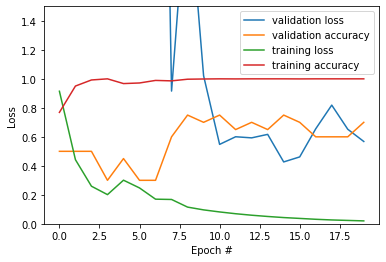

In [12]:
plt.figure()

fig, ax = plt.subplots()
ax.plot(history.history['val_loss'], label = "validation loss")
ax.plot(history.history['val_binary_accuracy'], label = "validation accuracy")
ax.plot(history.history['loss'], label = "training loss")
ax.plot(history.history['binary_accuracy'], label = "training accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.ylim(0, 1.5)
ax.legend()
plt.show()

In [7]:
# model = load_model('C:\\Users\\user\\saved_models\\basic_alldata_1.h5')
# model.evaluate_generator(generator = validation_generator, verbose = 1)

test_generator.reset()
pred = model.predict_generator(test_generator,
                               steps = STEP_SIZE_TEST,
                               verbose = 1)

Instructions for updating:
Please use Model.predict, which supports generators.
2700/2700 [==============================] - 124s 46ms/step


In [8]:
test_labels = []
for filename in os.listdir('c:\\Users\\user\\chair_model\\test\\test_folder'):
    if 'empty' in filename:
        test_labels.append(0)
    else:
        test_labels.append(1)
print(len(test_labels))

2700


In [9]:
threshold = 0.5
pred_labels = []
for i in pred:
    if i >= threshold:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print(len(pred_labels))

2700


In [10]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

results = confusion_matrix(test_labels, pred_labels) 
  
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :', accuracy_score(test_labels, pred_labels))
print('Report : ')
print(classification_report(test_labels, pred_labels))

Confusion Matrix :
[[ 392  958]
 [  89 1261]]
Accuracy Score : 0.6122222222222222
Report : 
              precision    recall  f1-score   support

           0       0.81      0.29      0.43      1350
           1       0.57      0.93      0.71      1350

    accuracy                           0.61      2700
   macro avg       0.69      0.61      0.57      2700
weighted avg       0.69      0.61      0.57      2700



In [31]:
MODELFILENAME = 'basic_alldata_1.h5'
MODELPATH = 'C:\\Users\\user\\saved_models'
model.save(os.path.join(MODELPATH, MODELFILENAME))

In [17]:
# write an annotated output video
# #of predictions must match number of frames in the video
OUTPUT_VIDEO_DIR = 'C:\\Users\\user\\chair_model'

def create_output_video(
    predictions,
    input_vid_location,
    out_location=OUTPUT_VIDEO_DIR,
    frame_jump = 1,
    out_name = None,
):
    """take in a video and create an output video with annotated predictions on it

    Parameters
    ----------
    predictions : list
        list of predictions for every frame in the video
    input_video_location : str
        path to saved input fideo to run on
    out_location : str
        path to write the annotated video to
    frame_jump : int
        runt/ write predictions on every nth frame, 1 would be predicting writing to every frame
    out_name : str
        override path and file name to write the video to
    Returns
    -------
    output_video_location: str
        where the annotated video was written to

    """
    # initialize the video stream, pointer to output video file, and
    # frame dimensions
    print("processing video :", input_vid_location)

    if out_name:
        outputFileName = out_name
    else:
        outputFileName = "annotated_" + os.path.basename(input_vid_location)
    output_video_location = os.path.join(out_location, outputFileName)

    vs = cv2.VideoCapture(input_vid_location)

    fps = vs.get(cv2.CAP_PROP_FPS)
    length = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
    if length != len(predictions):
        print("frames and video length do not match. num frames = ", length)
        return None

    writer = None
    (W, H) = (None, None)
    # loop over frames from the video file stream
    pred_count = 0
    text = "bed score prediction"
    while True:
        # read the next frame from the file
        (grabbed, frame) = vs.read()
        # if the frame was not grabbed, then we have reached the end
        # of the stream
        if not grabbed:
            break
        # if the frame dimensions are empty, grab them
        if W is None or H is None:
            (H, W) = frame.shape[:2]
        output = frame.copy()
        # draw the activity on the output frame

        if (pred_count % frame_jump) == 0:
            text = f"Chair Score: {predictions[pred_count]}"
            # print("writing prediction ", pred_count, text)
        pred_count += 1
        cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 0), 5)
        # check if the video writer is None
        if writer is None:
            # initialize our video writer
            fourcc = cv2.VideoWriter_fourcc(*"MP4V")
            writer = cv2.VideoWriter(output_video_location, fourcc, fps, (W, H), True)

        # write the output frame to disk
        writer.write(output)
        # print("wrote frame")

    # release the file pointers
    print("[INFO] cleaning up...")
    if writer:
        writer.release()
        out = output_video_location
    else:
        out = output_img_location
    vs.release()
    return output_video_location

In [33]:
create_output_video(pred_labels[:1350], 
                    'C:\\Users\\user\\chair_model\\test_videos\\empty_chair_90.mp4')

processing video : C:\Users\user\chair_model\test_videos\empty_chair_90.mp4
[INFO] cleaning up...


'C:\\Users\\user\\chair_model\\annotated_empty_chair_90.mp4'